## Bibliotecas Utilizadas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import spacy
import regex as re
from collections import Counter
from operator import itemgetter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
# Function to remove emoji.
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [4]:
def tokenize(texto):
    doc = nlp.tokenizer(texto)
    return [token.lower_ for token in doc if not token.is_punct]

In [5]:
def unnest_tokens(df, # Data Frame (em linhas)
                  coluna_tokenize, # nome da coluna com os textos (tweets)
                  coluna_token_nome='palavra', # nome da coluna com os tokens
                  tokenizer_function=tokenize): # what tokenizer to use
    
    return (df[coluna_tokenize]
              .apply(tokenizer_function)
              .apply(pd.Series)
              .stack()
              .reset_index(level=0)
              .set_index('level_0')
              .rename(columns={0: coluna_token_nome})
              .join(df.drop(coluna_tokenize, 1), how='left')
              .reset_index(drop=True))

In [6]:
def clean_stopwords(df, coluna_token="palavra"):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    df = df[~ df[coluna_token].isin(stop_words_portugues | stop_words_ingles | stop_words_espanhol | symbols)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if re.match(r'http*', w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if emoji_pattern.match(w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if (w.startswith('@') | w.startswith('#') | w.startswith('\r')))]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if w == 'rt')]
    return df

# Carregando os dados 

In [7]:
# Dataframe com todos os politicos e seus tweets
lista_dir = os.listdir("./politicos/")
nome_politicos = []
df_politicos = pd.DataFrame()
for nome in lista_dir:
    df_politico = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    df_politico['nome'] = nome[:-4]
    nome_politicos.append(nome[:-4])
    df_politicos = df_politicos.append(df_politico)
cols = ['nome'] + [col for col in df_politicos if col != 'nome']
df_politicos = df_politicos[cols]
df_politicos.reset_index(inplace=True)

In [8]:
df_politicos.head(10)

index    nome            created_at  \
0      0  Amoedo  2021-04-19T16:18:20Z   
1      1  Amoedo  2021-04-19T16:05:53Z   
2      2  Amoedo  2021-04-19T15:32:40Z   
3      3  Amoedo  2021-04-19T12:53:14Z   
4      4  Amoedo  2021-04-19T12:25:58Z   
5      5  Amoedo  2021-04-19T12:19:42Z   
6      6  Amoedo  2021-04-18T19:21:07Z   
7      7  Amoedo  2021-04-18T19:21:06Z   
8      8  Amoedo  2021-04-18T15:42:35Z   
9      9  Amoedo  2021-04-18T15:42:25Z   

                                                text                   id  
0  RT @MBLivre: Presidente americano Joe Biden an...  1384179569712713735  
1  Temos que fazer a nossa parte. Não podemos dei...  1384176435552608259  
2  O governo federal e o Congresso ignoraram no O...  1384168077697314825  
3  RT @o_antagonista: .@joaoamoedonovo sugeriu no...  1384127951311040517  
4                     Informações de @OGloboPolitica  1384121090243383296  
5  A CPI da Pandemia no Senado deve investigar o ...  1384119514418216969  
6  Leia a coluna completa em https://t.co/rvNDUpnqgA  1383863178853969921  
7  "Membros do Executivo e do Legislativo não ace...  1383863176891015168  
8                       Informações de @RevistaEpoca  1383808183223734272  
9  O governo federal gastará R$500 mil em uma cam...  1383808141897342986

In [9]:
df_politicos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31633 entries, 0 to 31632
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       31633 non-null  int64 
 1   nome        31633 non-null  object
 2   created_at  31633 non-null  object
 3   text        31633 non-null  object
 4   id          31633 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


# WordClouds e outras análises

In [10]:
# stopwords e simbolos a retirar
stop_words_portugues = set(stopwords.words('portuguese'))
stop_words_ingles = set(stopwords.words('english'))
stop_words_espanhol = set(stopwords.words('spanish'))
symbols = set(['-', 'r$', 'R$', '|'])

In [11]:
nlp = spacy.load("pt_core_news_sm")

In [12]:
# criando dataframe apenas com as palavras e os politicos
df_palavras = unnest_tokens(df_politicos.drop(['index','created_at','id'], axis=1), 'text')

In [13]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905721 entries, 0 to 905720
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  905721 non-null  object
 1   nome     905721 non-null  object
dtypes: object(2)
memory usage: 13.8+ MB


In [14]:
df_palavras = clean_stopwords(df_palavras)

In [15]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481396 entries, 2 to 905720
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  481396 non-null  object
 1   nome     481396 non-null  object
dtypes: object(2)
memory usage: 11.0+ MB


In [16]:
df_palavras.head()

palavra    nome
2  presidente  Amoedo
3   americano  Amoedo
4         joe  Amoedo
5       biden  Amoedo
6     anuncia  Amoedo

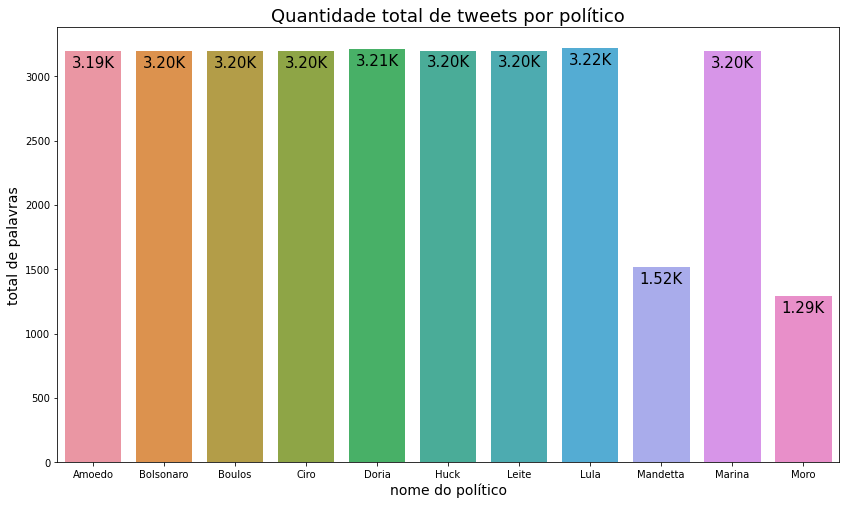

In [17]:
#quantidade de tweets por político

df_plot = df_politicos.groupby('nome').agg(total =('text','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de palavras", size=14)
plt.title("Quantidade total de tweets por político", size=18)
for p in splot.patches:
    splot.annotate(format((p.get_height()/1000), '.2f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

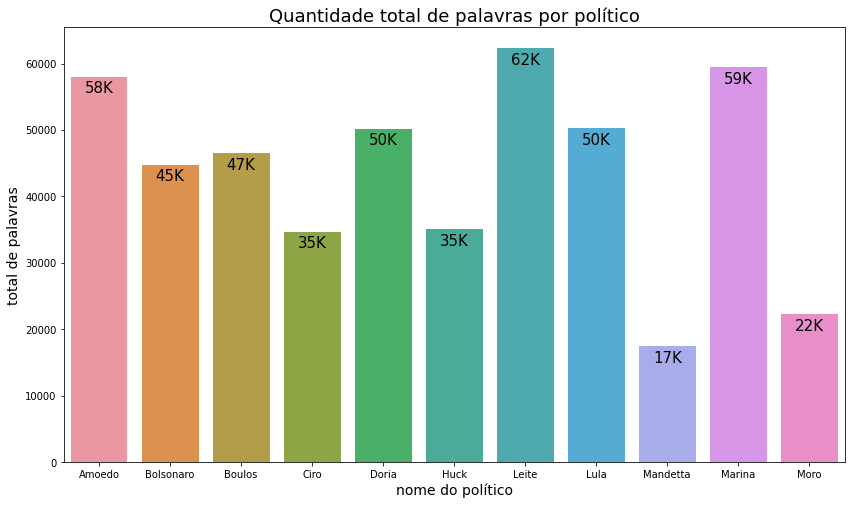

In [18]:
# quantidade de palavras por político

df_plot = df_palavras.groupby('nome').agg(total =('palavra','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de palavras", size=14)
plt.title("Quantidade total de palavras por político", size=18)
for p in splot.patches:
    splot.annotate(format(round(p.get_height()/1000), '.0f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

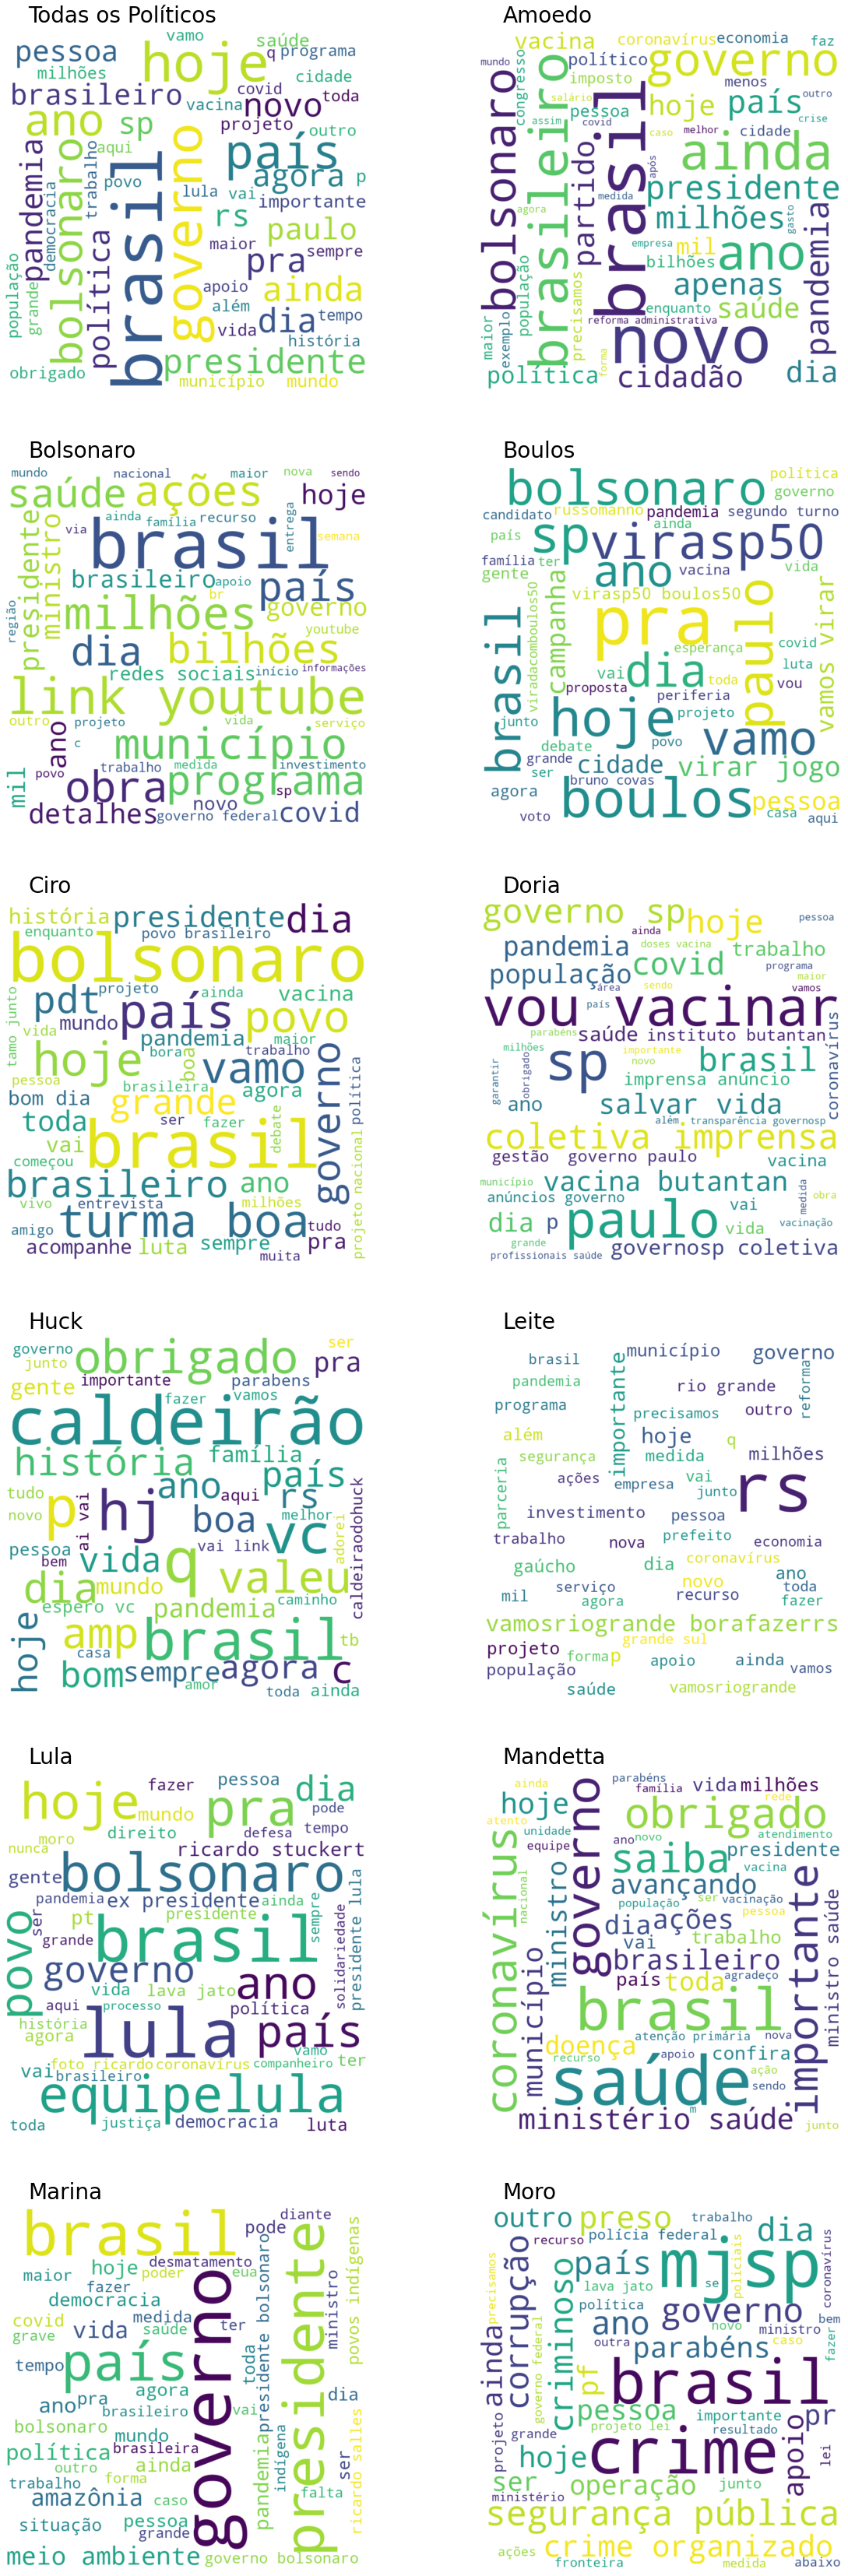

In [59]:
# wordcloud por político
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 60), facecolor='w')
xc = 0
yc = 1
sumario = " ".join(s for s in df_palavras['palavra'])
wordcloud = WordCloud(width=800, height=800, max_words=50, max_font_size=150, background_color='white').generate(sumario)
ax[0][0].imshow(wordcloud, interpolation="bilinear")
ax[0][0].text(50, -20, 'Todas os Políticos', fontsize=28, color='k')
ax[0][0].axis('off')

for idx in range(11):
    sumario = " ".join(s for s in df_palavras['palavra'][df_palavras['nome'] == nome_politicos[idx]])
    wordcloud = WordCloud(width=800, height=800, max_words=50, max_font_size=150, 
            background_color='white').generate(sumario)
    ax[xc][yc].imshow(wordcloud, interpolation="bilinear")
    ax[xc][yc].text(50, -20, nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].axis('off')
    yc += 1
    if (yc == 2):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

#plt.tight_layout(pad=0) 
plt.show()

# Análise de frequências

In [45]:
# montando dataframe de frequências

c = Counter(df_palavras['palavra']).most_common()
df_palavras_qtd = pd.DataFrame(c, columns=['palavra', 'qtd'])
for politico in nome_politicos:
    c = Counter(df_palavras['palavra'][df_palavras['nome'] == politico]).most_common()
    d = pd.DataFrame(c, columns=['palavra', politico])
    #d[f'f-{politico}'] = d[politico] / df_palavras_qtd['qtd']
    df_palavras_qtd = pd.merge(df_palavras_qtd, d, on='palavra')

In [55]:
df_palavras_qtd

palavra   qtd  Amoedo  Bolsonaro  Boulos  Ciro  Doria  Huck  Leite  \
0       brasil  3492     529        406     211   461    248   226    100   
1      governo  2907     292        240     160   213    470    35    284   
2         hoje  2275     142        116     284   237    319   125    423   
3        saúde  2040     212        152     121   149    337    88    227   
4    bolsonaro  2032     276         77     285   618     39     1      6   
..         ...   ...     ...        ...     ...   ...    ...   ...    ...   
940   terceiro    26       4          1       1     3      3     3      2   
941     chegam    24       2          5       1     1      4     2      1   
942    desejar    22       1          1       3     5      2     2      1   
943    pequena    21       4          3       2     1      1     1      2   
944  brilhante    19       1          1       1     2      7     1      1   

     Lula  Mandetta  Marina  Moro  
0     483       197     488   143  
1     215       153     715   130  
2     290        70     208    61  
3     104       445     186    19  
4     361        17     340    12  
..    ...       ...     ...   ...  
940     3         3       1     2  
941     2         2       3     1  
942     1         3       1     2  
943     1         2       3     1  
944     2         1       1     1  

[945 rows x 13 columns]

In [54]:
df_palavras_freq = df_palavras_qtd.copy()
for politico in nome_politicos:
     df_palavras_freq[politico] =  df_palavras_qtd[politico]/df_palavras_qtd['qtd']

df_palavras_freq

palavra   qtd    Amoedo  Bolsonaro    Boulos      Ciro     Doria  \
0       brasil  3492  0.151489   0.116266  0.060424  0.132016  0.071019   
1      governo  2907  0.100447   0.082559  0.055040  0.073271  0.161679   
2         hoje  2275  0.062418   0.050989  0.124835  0.104176  0.140220   
3        saúde  2040  0.103922   0.074510  0.059314  0.073039  0.165196   
4    bolsonaro  2032  0.135827   0.037894  0.140256  0.304134  0.019193   
..         ...   ...       ...        ...       ...       ...       ...   
940   terceiro    26  0.153846   0.038462  0.038462  0.115385  0.115385   
941     chegam    24  0.083333   0.208333  0.041667  0.041667  0.166667   
942    desejar    22  0.045455   0.045455  0.136364  0.227273  0.090909   
943    pequena    21  0.190476   0.142857  0.095238  0.047619  0.047619   
944  brilhante    19  0.052632   0.052632  0.052632  0.105263  0.368421   

         Huck     Leite      Lula  Mandetta    Marina      Moro  
0    0.064719  0.028637  0.138316  0.056415  0.139748  0.040951  
1    0.012040  0.097695  0.073959  0.052632  0.245958  0.044720  
2    0.054945  0.185934  0.127473  0.030769  0.091429  0.026813  
3    0.043137  0.111275  0.050980  0.218137  0.091176  0.009314  
4    0.000492  0.002953  0.177657  0.008366  0.167323  0.005906  
..        ...       ...       ...       ...       ...       ...  
940  0.115385  0.076923  0.115385  0.115385  0.038462  0.076923  
941  0.083333  0.041667  0.083333  0.083333  0.125000  0.041667  
942  0.090909  0.045455  0.045455  0.136364  0.045455  0.090909  
943  0.047619  0.095238  0.047619  0.095238  0.142857  0.047619  
944  0.052632  0.052632  0.105263  0.052632  0.052632  0.052632  

[945 rows x 13 columns]

Text(0.5, 1.0, 'Frequência das palavras')

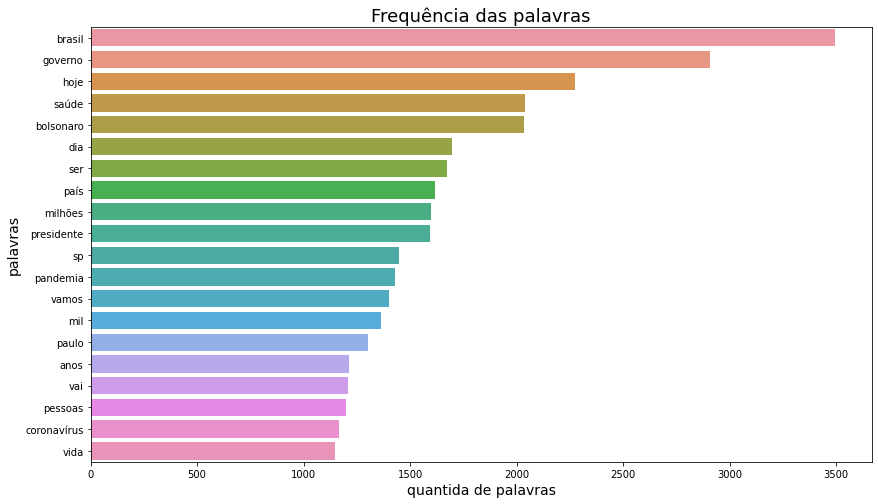

In [58]:
# quantidade de palavras por político
df_plot = df_palavras_freq[:20]

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="qtd", y="palavra", data=df_plot)
plt.xlabel("quantida de palavras", size=14)
plt.ylabel("palavras", size=14)
plt.title("Frequência das palavras", size=18)

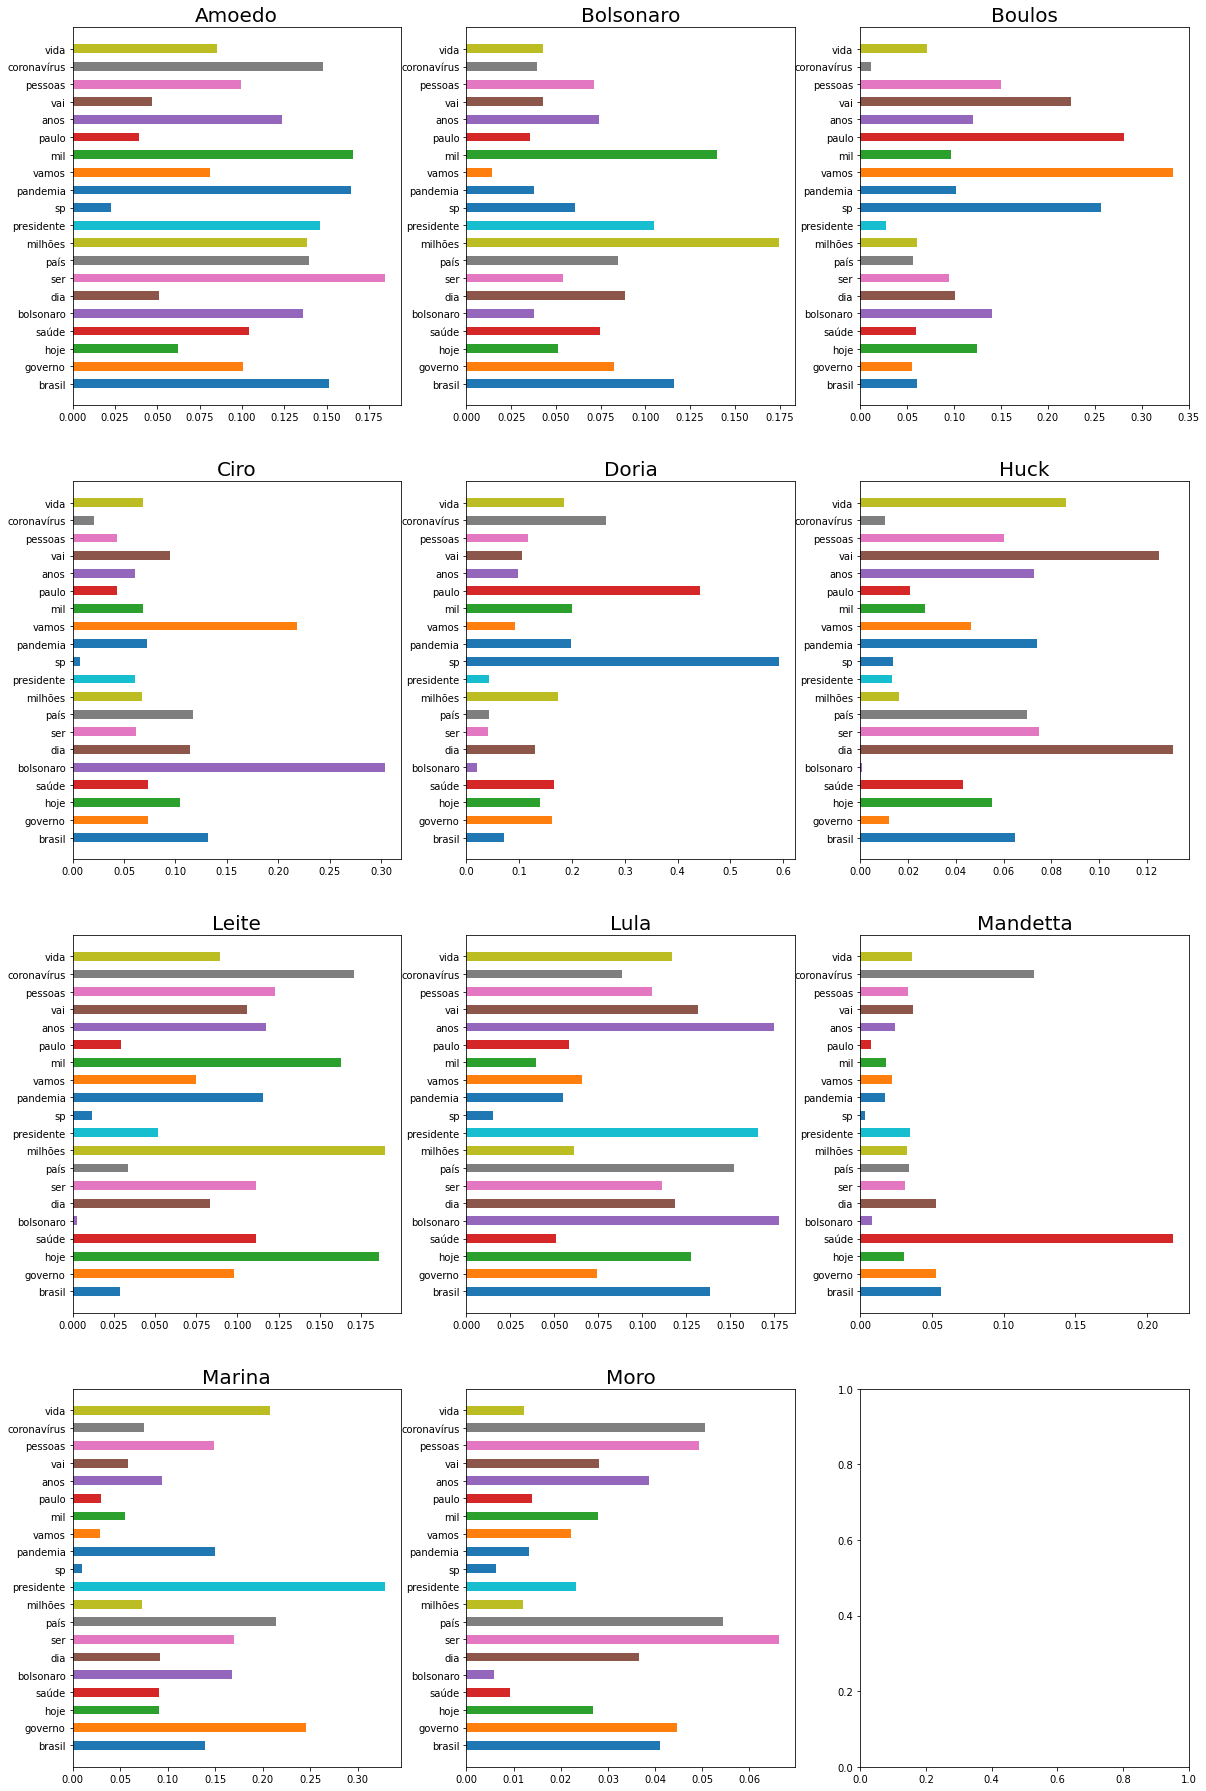

In [119]:
colors = [f'C{x}' for x in range(11)]
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 32), facecolor='w')
xc=0
yc=0
for idx in range(11):
    ax[xc][yc].barh(y=df_plot['palavra'], width=df_plot[nome_politicos[idx]], height=0.5, color=colors)
    ax[xc][yc].set_title(nome_politicos[idx], fontsize=20, color='black')
    yc += 1
    if (yc == 3):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.show()